In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import glob
import os
import simdkalman
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter("ignore")

### 事前準備

#### 関数準備

##### GNSSファイル読み込み
gnss_log_to_dataframes(path)

In [2]:

# from https://www.kaggle.com/sohier/loading-gnss-logs
def gnss_log_to_dataframes(path):
    
    gnss_section_names = {'Raw','UncalAccel', 'UncalGyro', 'UncalMag', 'Fix', 'Status', 'OrientationDeg'}
    with open(path) as f_open:
        datalines = f_open.readlines()

    datas = {k: [] for k in gnss_section_names}
    gnss_map = {k: [] for k in gnss_section_names}
    for dataline in datalines:
        is_header = dataline.startswith('#')
        dataline = dataline.strip('#').strip().split(',')
        # skip over notes, version numbers, etc
        if is_header and dataline[0] in gnss_section_names:
            gnss_map[dataline[0]] = dataline[1:]
        elif not is_header:
            datas[dataline[0]].append(dataline[1:])

    results = dict()
    for k, v in datas.items():
        results[k] = pd.DataFrame(v, columns=gnss_map[k])
    # pandas doesn't properly infer types from these lists by default
    for k, df in results.items():
        for col in df.columns:
            if col == 'CodeType':
                continue
            results[k][col] = pd.to_numeric(results[k][col])

    return results

#### カルマンフィルター
apply_kf_smoothing(df,kf_)

In [83]:
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])


process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
print(state_transition )

[[1.  0.  1.  0.  0.5 0. ]
 [0.  1.  0.  1.  0.  0.5]
 [0.  0.  1.  0.  1.  0. ]
 [0.  0.  0.  1.  0.  1. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  1. ]]


In [88]:
T = 1.0


state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])


process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
print(process_noise)

observation_model = np.array([[1, 0, 0, 0, 0, 0]])

observation_noise = np.diag([5e-5]) 


def apply_kf_smoothing(df,headers,kf=kf_):
        
    df_set = [];
    
    kf_in_func = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise
    
    )

    
    
    
    data_df = df[headers];
        
    data = data_df.to_numpy();
    data = data.reshape(1,len(data),len(headers));        
    
    smoothed = kf_in_func.smooth(data)
        
    
    for idx,head in enumerate(headers):
        data_df[head] =  smoothed.states.mean[0, :, idx]

    df_set.append(data_df); 

    modified = pd.concat(df_set);

    df[headers] = modified[headers]    
    
    return df
    

[[1.0001e-05 1.0000e-09 1.0000e-09 1.0000e-09 1.0000e-09 1.0000e-09]
 [1.0000e-09 1.0001e-05 1.0000e-09 1.0000e-09 1.0000e-09 1.0000e-09]
 [1.0000e-09 1.0000e-09 5.0010e-06 1.0000e-09 1.0000e-09 1.0000e-09]
 [1.0000e-09 1.0000e-09 1.0000e-09 5.0010e-06 1.0000e-09 1.0000e-09]
 [1.0000e-09 1.0000e-09 1.0000e-09 1.0000e-09 1.0010e-06 1.0000e-09]
 [1.0000e-09 1.0000e-09 1.0000e-09 1.0000e-09 1.0000e-09 1.0010e-06]]


#### ファイルパス生成

In [4]:
train_path  = "/work/data/input/google-smartphone-decimeter-challenge/train"


target_paths = [ glob.glob(f"{f}/*")[0]+"/" + glob.glob(f"{f}/*")[0].split("/")[-1]+"_GnssLog.txt"  for f in glob.glob(f"{train_path}/*")  ]

display(target_paths)

['/work/data/input/google-smartphone-decimeter-challenge/train/2020-06-04-US-MTV-1/Pixel4/Pixel4_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-05-21-US-MTV-2/Pixel4/Pixel4_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-07-17-US-MTV-1/Mi8/Mi8_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-09-04-US-SF-1/Pixel4/Pixel4_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-07-17-US-MTV-2/Mi8/Mi8_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-05-29-US-MTV-1/Pixel4/Pixel4_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2021-01-04-US-RWC-1/Pixel4Modded/Pixel4Modded_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-08-03-US-MTV-1/Pixel4/Pixel4_GnssLog.txt',
 '/work/data/input/google-smartphone-decimeter-challenge/train/2020-05-14-US-MTV-2/Pixel4/Pixel4_GnssLog.txt',
 '

0it [00:00, ?it/s]

IndexError: index -1 is out of bounds for axis 1 with size 0

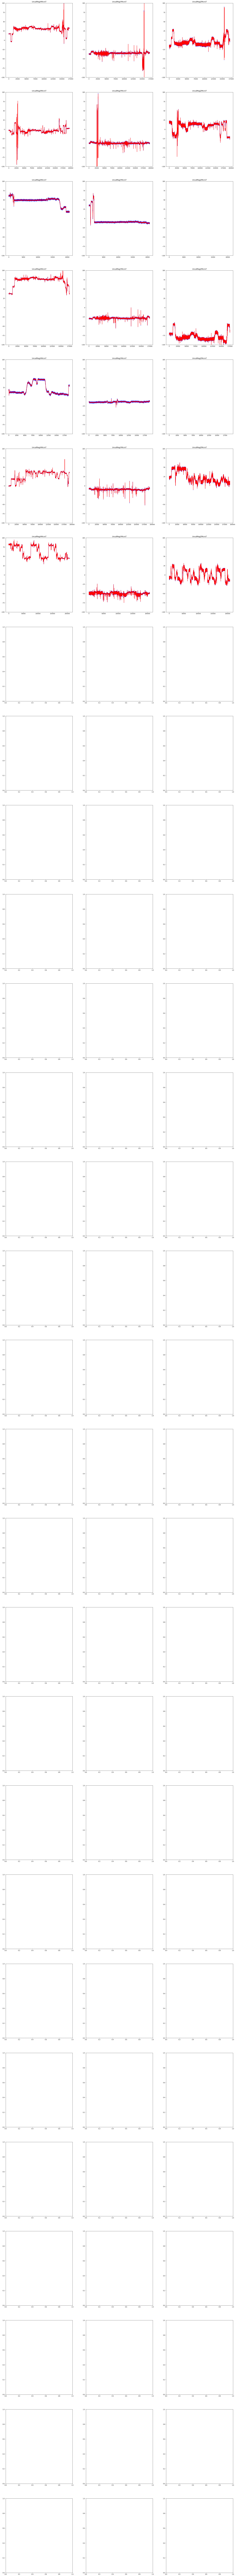

In [101]:

startPoint = 0
endPoint = len(target_paths)
y_limit_threshhold =100

fig, axes = plt.subplots(nrows= (endPoint-startPoint), ncols=3, figsize=(30, 12*(endPoint-startPoint)))

for path_idx,path in tqdm(enumerate(target_paths[startPoint:endPoint])):        
    dfs = gnss_log_to_dataframes(path)    
    df_magn = dfs["UncalMag"];
    
    df_magn["utcTimeMillis"] = df_magn["utcTimeMillis"] - df_magn["utcTimeMillis"].min()    
    headers = ["UncalMagXMicroT","UncalMagYMicroT","UncalMagZMicroT"]        
    filterd = df_magn.copy();
            
    for head_idx,head in enumerate(headers):        
        apply_kf_smoothing(filterd,[head])
        df_magn[head].plot(ax=axes[path_idx][head_idx],title=head,ylim=[-1*y_limit_threshhold,y_limit_threshhold],color='b');
        filterd[head].plot(ax=axes[path_idx][head_idx],title=head,ylim=[-1*y_limit_threshhold,y_limit_threshhold],color='r');        